In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Using pip install to install those package


# US

### Read Data

In [2]:
# Interest Rate
fed_funds = pd.read_csv('./Data/US/FEDFUNDS.csv')
# Indices Data
sp500 = pd.read_csv('./Data/US/S&P 500 Historical Price Data.csv')
# Inflation Data
us_inflation = pd.read_csv('./Data/US/US Inflation Rate.csv')
# GDP Growth Rate
us_gdp = pd.read_csv('./Data/US/USGDP.csv')
# CCI Data
us_cci = pd.read_csv('./Data/US/US CCI.csv')

In [3]:
fed_funds['observation_date'] = pd.to_datetime(fed_funds['observation_date'], format='%Y-%m-%d')

us_inflation['Date'] = pd.to_datetime(us_inflation['Date'], format='%b-%y')

sp500['Date'] = pd.to_datetime(sp500['Date'])

def convert_year_to_date(year):
    return pd.to_datetime(f"{year}-01-01")

us_gdp['Date'] = us_gdp['Date'].apply(convert_year_to_date)
us_gdp['Date'] = pd.to_datetime(us_gdp['Date'])

us_cci['Release Date'] = pd.to_datetime(us_cci['Release Date'], format='%d/%m/%Y')


### Merge Data

In [4]:
# Convert all to monthly data, using the average or last value
sp500 = sp500.set_index('Date').resample('M').last()
fed_funds = fed_funds.set_index('observation_date').resample('M').last()
us_inflation = us_inflation.set_index('Date').resample('M').last()
us_gdp = us_gdp.set_index('Date').resample('M').last()
us_cci = us_cci.set_index('Release Date').resample('M').last()

In [5]:
# 提取年份
years = us_gdp.index.year

# 用1月份的数据填充NaN
for year in set(years):
    january_value = us_gdp.loc[(us_gdp.index.year == year) & (us_gdp.index.month == 1), 'GDP growth'].values[0]
    us_gdp.loc[us_gdp.index.year == year, 'GDP growth'] = us_gdp.loc[us_gdp.index.year == year, 'GDP growth'].fillna(january_value)
    
# 提取年份
years = us_cci.index.year

# 用1月份的数据填充NaN
for year in set(years):
    january_value = us_cci.loc[(us_cci.index.year == year) & (us_cci.index.month == 1), 'CCI Rate'].values[0]
    us_cci.loc[us_cci.index.year == year, 'CCI Rate'] = us_cci.loc[us_cci.index.year == year, 'CCI Rate'].fillna(january_value)

In [6]:
# Merge datasets on the date index
df = pd.concat([sp500[['Price']], fed_funds['FEDFUNDS'], us_inflation['Inflation'], us_gdp['GDP growth'], us_cci['CCI Rate']], axis=1)
df.columns = ['SP500_Price', 'FEDFUNDS', 'US_Inflation', 'GDP growth', 'CCI Rate']


### Data Cleaning

In [7]:
# Conver data from Object type to float type
df['SP500_Price'] = df['SP500_Price'].replace('[\$,]', '', regex=True)
df['SP500_Price'] = pd.to_numeric(df['SP500_Price'], errors='coerce')
df.dropna(inplace=True)


In [8]:
def plot_and_save(x, y1, y2, y1_label, y2_label, y1_color, y2_color, filename):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, y1, color=y1_color, label=y1_label)
    ax.set_ylabel(y1_label, color=y1_color)
    ax.tick_params(axis='y', labelcolor=y1_color)
    
    ax2 = ax.twinx()
    ax2.plot(x, y2, color=y2_color, label=y2_label)
    ax2.set_ylabel(y2_label, color=y2_color)
    ax2.tick_params(axis='y', labelcolor=y2_color)
    ax.grid(True)
    
    ax.set_xlabel('Date')
    
    plt.title(f'{y1_label} and {y2_label} Over Time')
    fig.tight_layout()
    plt.savefig('./fig/Bare Eye Analysis/US/' + filename)
    plt.close(fig)

# SP500_Price 和 FEDFUNDS
plot_and_save(df.index, df['SP500_Price'], df['FEDFUNDS'], 'SP500 Price', 'Fed Funds Rate', 'b', 'g', 'sp500_fedfunds.png')

# SP500_Price 和 US_Inflation
plot_and_save(df.index, df['SP500_Price'], df['US_Inflation'], 'SP500 Price', 'US Inflation Rate', 'b', 'r', 'sp500_inflation.png')

# SP500_Price 和 GDP growth
plot_and_save(df.index, df['SP500_Price'], df['GDP growth'], 'SP500 Price', 'GDP Growth', 'b', 'c', 'sp500_gdp.png')

# SP500_Price 和 CCI Rate
plot_and_save(df.index, df['SP500_Price'], df['CCI Rate'], 'SP500 Price', 'CCI Rate', 'b', 'm', 'sp500_cci.png')


In [9]:
from sklearn.preprocessing import MinMaxScaler

# Nomarlise the data
scaler = MinMaxScaler()
df['FEDFUNDS_adj'] = scaler.fit_transform(df[['FEDFUNDS']])
df['SP500_Price_adj'] = scaler.fit_transform(df[['SP500_Price']])
df['US_Inflation_adj'] = scaler.fit_transform(df[['US_Inflation']])
df['GDP_growth_adj'] = scaler.fit_transform(df[['GDP growth']])
df['CCI_Rate_adj'] = scaler.fit_transform(df[['CCI Rate']])

### Regression Analysis

#### Laggin Effect

In [10]:
# Creating lagged variables
df['FEDFUNDS_lag1'] = df['FEDFUNDS_adj'].shift(3)  # 1-month lag
df['FEDFUNDS_lag6'] = df['FEDFUNDS_adj'].shift(6)  # 6-months lag
df['FEDFUNDS_lag12'] = df['FEDFUNDS_adj'].shift(12)  # 12-months lag

df['US_Inflation_lag1'] = df['US_Inflation_adj'].shift(-1)  # 1-month lag

df['CCI_Rate_lag6'] = df['CCI_Rate_adj'].shift(6)  # 6-months lag

df['GDP_Growth_lag12'] = df['GDP_growth_adj'].shift(12)  # 12-months lag

#### Regression

                            OLS Regression Results                            
Dep. Variable:        SP500_Price_adj   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     39.47
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           3.96e-18
Time:                        22:56:04   Log-Likelihood:                 40.637
No. Observations:                  84   AIC:                            -71.27
Df Residuals:                      79   BIC:                            -59.12
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1691      0.046  

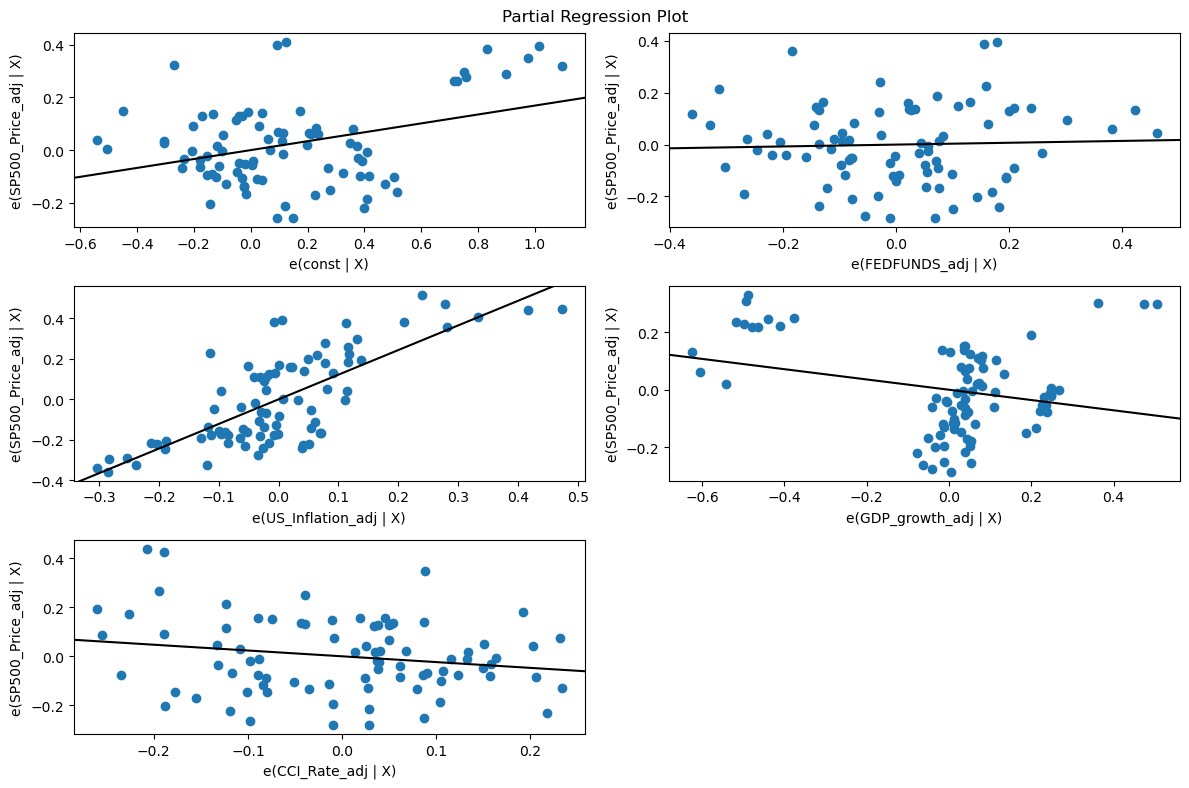

In [11]:
X = df[['FEDFUNDS_adj', 'US_Inflation_adj', 'GDP_growth_adj', 'CCI_Rate_adj']]
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = df['SP500_Price_adj']

X.dropna(inplace=True)
y = y.loc[X.index]

model = sm.OLS(y, X).fit()
print(model.summary())

# Plot partial regression plots
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)

# fig.savefig('./fig/graph_' + x + '.png')

with open('./Results/regression_summary_' + 'FEDFUNDS, US_Inflation, GDP growth, CCI Rate' + '.txt', 'w') as file:
    file.write(model.summary().as_text())

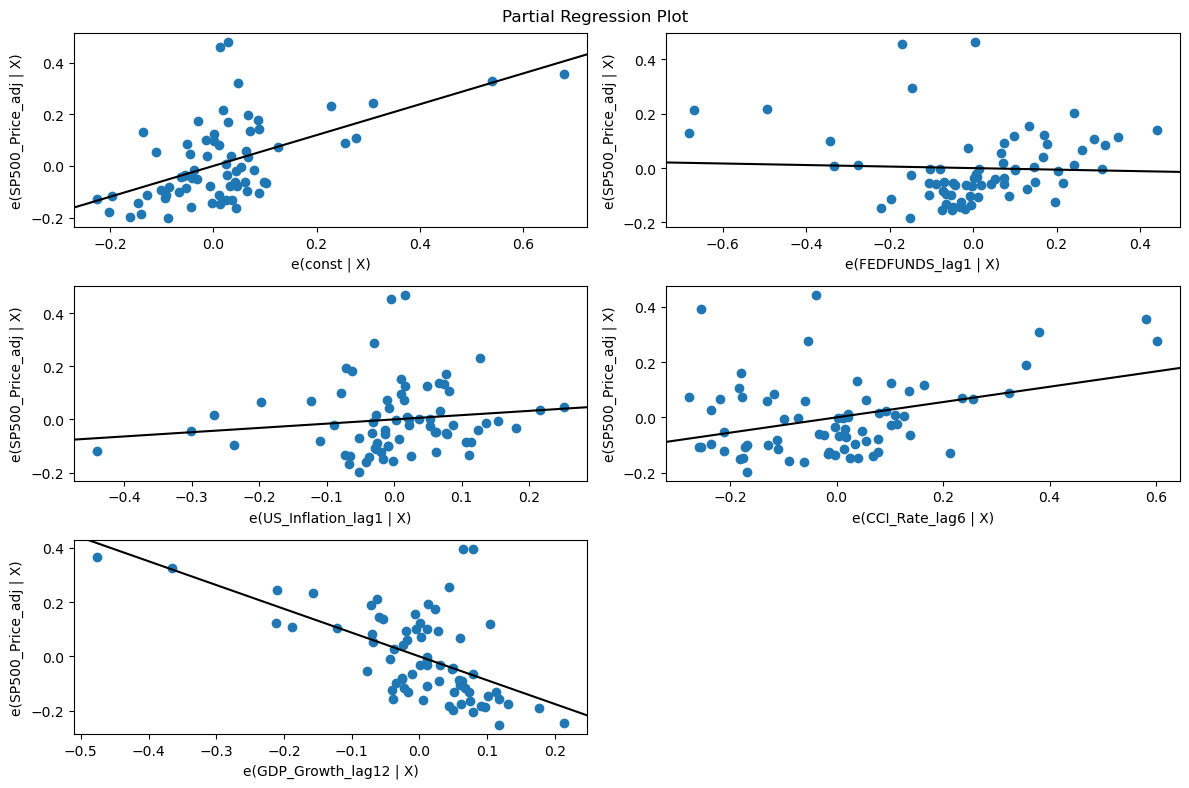

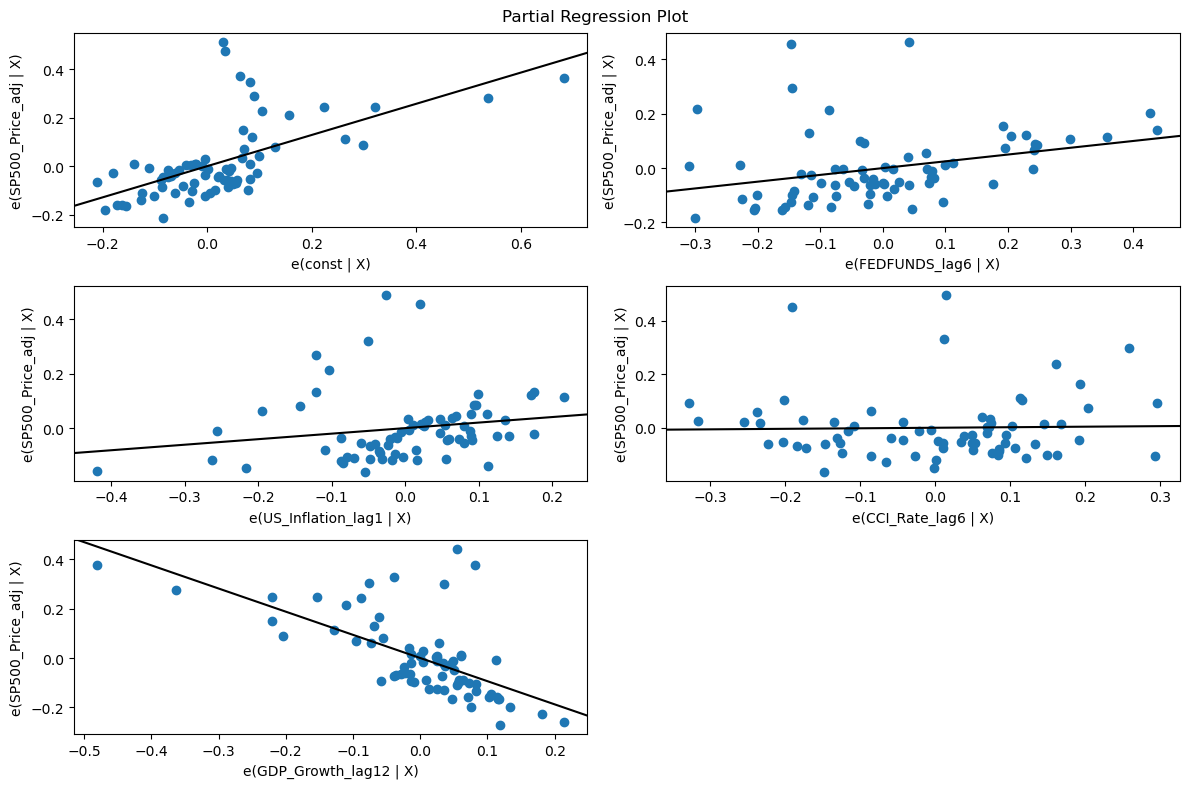

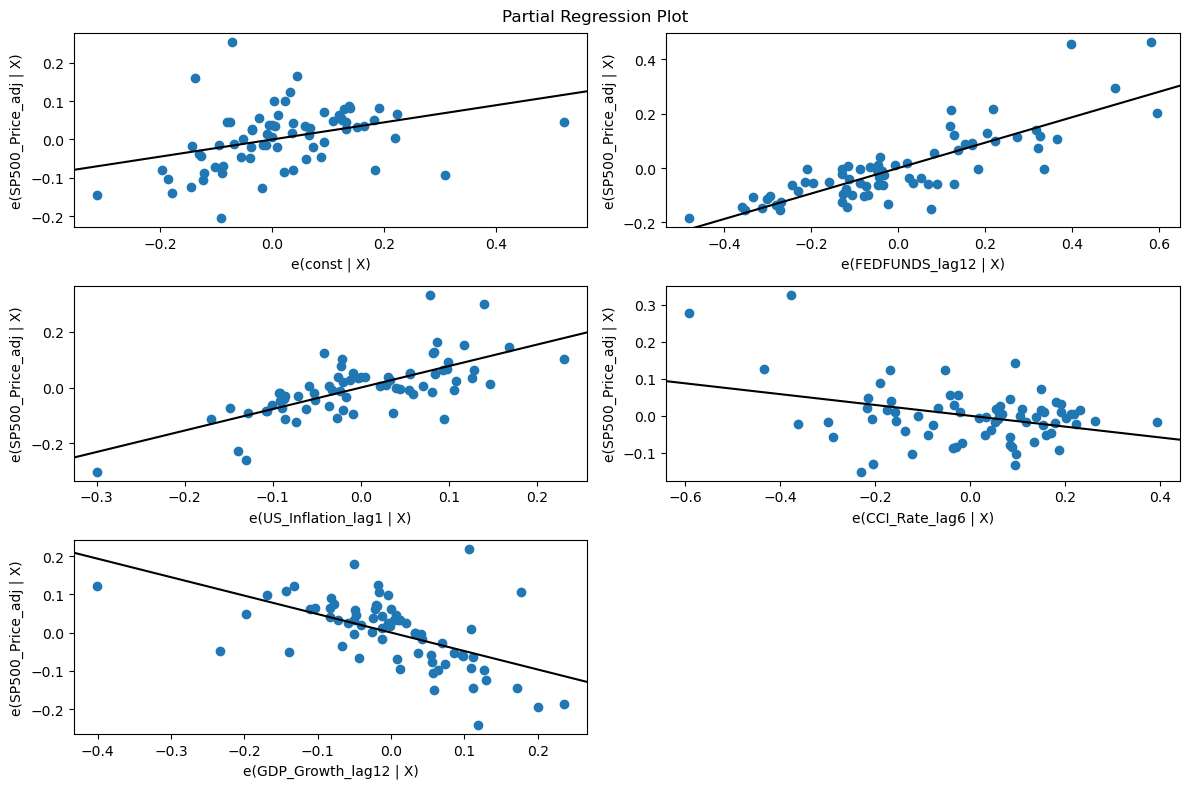

In [12]:
for x in ['FEDFUNDS_lag1', 'FEDFUNDS_lag6', 'FEDFUNDS_lag12']:
    X = df[[x, 'US_Inflation_lag1', 'CCI_Rate_lag6', 'GDP_Growth_lag12']]
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    y = df['SP500_Price_adj']
    
    X.dropna(inplace=True)
    y = y.loc[X.index]
    
    model = sm.OLS(y, X).fit()
    
    # Plot partial regression plots
    fig = plt.figure(figsize=(12, 8))
    fig = sm.graphics.plot_partregress_grid(model, fig=fig)
    
    fig.savefig('./fig/lags/US/graph_' + x + '.png')
    
    with open('./Results/lags/US/regression_summary_' + x + '_lags.txt', 'w') as file:
        file.write(model.summary().as_text())

# UK

### Read Data

In [13]:
# Interest Rate
bank_rate = pd.read_csv('./Data/UK/BoE-Database_export.csv')
# Indices Data
ftse100 = pd.read_csv('./Data/UK/FTSE 100 Historical Price Data.csv')
# Inflation Data
uk_inflation = pd.read_csv('./Data/UK/UK Infation Rate.csv')
# GDP Growth Rate
uk_gdp = pd.read_csv('./Data/UK/UKGDP.csv')
# CCI Data
uk_cci = pd.read_csv('./Data/UK/UK CCI.csv')

In [14]:
bank_rate['Date'] = pd.to_datetime(bank_rate['Date'], format='%d/%m/%Y')

uk_inflation['Date'] = pd.to_datetime(uk_inflation['Date'], format='%b-%y')

ftse100['Date'] = pd.to_datetime(ftse100['Date'], format='%m/%d/%Y')

def convert_year_to_date(year):
    return pd.to_datetime(f"{year}-01-01")

uk_gdp['Date'] = uk_gdp['Date'].apply(convert_year_to_date)
uk_gdp['Date'] = pd.to_datetime(uk_gdp['Date'])


uk_cci['Date'] = pd.to_datetime(uk_cci['Date'], format='%d/%m/%Y')


### Merge Data

In [15]:
# Convert all to monthly data, using the average or last value
ftse100 = ftse100.set_index('Date').resample('M').last()
bank_rate = bank_rate.set_index('Date').resample('M').last()
uk_inflation = uk_inflation.set_index('Date').resample('M').last()
uk_gdp = uk_gdp.set_index('Date').resample('M').last()
uk_cci = uk_cci.set_index('Date').resample('M').last()

In [16]:
# 提取年份
years = uk_gdp.index.year

# 用1月份的数据填充NaN
for year in set(years):
    january_value = uk_gdp.loc[(uk_gdp.index.year == year) & (uk_gdp.index.month == 1), 'GDP growth'].values[0]
    uk_gdp.loc[uk_gdp.index.year == year, 'GDP growth'] = uk_gdp.loc[uk_gdp.index.year == year, 'GDP growth'].fillna(january_value)
    
# 提取年份
years = uk_cci.index.year

# 用1月份的数据填充NaN
for year in set(years):
    january_value = uk_cci.loc[(uk_cci.index.year == year) & (uk_cci.index.month == 1), 'CCI Rate'].values[0]
    uk_cci.loc[uk_cci.index.year == year, 'CCI Rate'] = uk_cci.loc[uk_cci.index.year == year, 'CCI Rate'].fillna(january_value)

In [17]:
# Merge datasets on the date index
df = pd.concat([ftse100[['Price']], bank_rate['Bank Rate'], uk_inflation['Inflation'], uk_gdp['GDP growth'], uk_cci['CCI Rate']], axis=1)
df.columns = ['FTSE100_Price', 'Bank_Rate', 'UK_Inflation', 'GDP_growth', 'CCI_Rate']


### Data Cleaning

In [18]:
# Conver data from Object type to float type
df['FTSE100_Price'] = df['FTSE100_Price'].replace('[\$,]', '', regex=True)
df['FTSE100_Price'] = pd.to_numeric(df['FTSE100_Price'], errors='coerce')
df.dropna(inplace=True)


In [19]:
def plot_and_save(x, y1, y2, y1_label, y2_label, y1_color, y2_color, filename):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, y1, color=y1_color, label=y1_label)
    ax.set_ylabel(y1_label, color=y1_color)
    ax.tick_params(axis='y', labelcolor=y1_color)
    
    ax2 = ax.twinx()
    ax2.plot(x, y2, color=y2_color, label=y2_label)
    ax2.set_ylabel(y2_label, color=y2_color)
    ax2.tick_params(axis='y', labelcolor=y2_color)
    ax.grid(True)
    
    ax.set_xlabel('Date')
    
    plt.title(f'{y1_label} and {y2_label} Over Time')
    fig.tight_layout()
    plt.savefig('./fig/Bare Eye Analysis/UK/' + filename)
    plt.close(fig)

# SP500_Price 和 FEDFUNDS
plot_and_save(df.index, df['FTSE100_Price'], df['Bank_Rate'], 'FTSE100 Price', 'BoE Interest Rate', 'b', 'g', 'FTSE100_BoE.png')

# SP500_Price 和 US_Inflation
plot_and_save(df.index, df['FTSE100_Price'], df['UK_Inflation'], 'FTSE100 Price', 'UK Inflation Rate', 'b', 'r', 'FTSE100_inflation.png')

# SP500_Price 和 GDP growth
plot_and_save(df.index, df['FTSE100_Price'], df['GDP_growth'], 'FTSE100 Price', 'GDP Growth', 'b', 'c', 'FTSE100_gdp.png')

# SP500_Price 和 CCI Rate
plot_and_save(df.index, df['FTSE100_Price'], df['CCI_Rate'], 'FTSE100 Price', 'CCI Rate', 'b', 'm', 'FTSE100_cci.png')


In [20]:
from sklearn.preprocessing import MinMaxScaler

# Nomarlise the data
scaler = MinMaxScaler()
df['Bank_Rate_adj'] = scaler.fit_transform(df[['Bank_Rate']])
df['FTSE100_Price_adj'] = scaler.fit_transform(df[['FTSE100_Price']])
df['UK_Inflation_adj'] = scaler.fit_transform(df[['UK_Inflation']])
df['GDP_growth_adj'] = scaler.fit_transform(df[['GDP_growth']])
df['CCI_Rate_adj'] = scaler.fit_transform(df[['CCI_Rate']])

### Regression Analysis

#### Lagging Effect

In [21]:
# Creating lagged variables
df['Bank_Rate_lag3'] = df['Bank_Rate_adj'].shift(3)  # 3-month lag
df['Bank_Rate_lag6'] = df['Bank_Rate_adj'].shift(6)  # 6-months lag
df['Bank_Rate_lag12'] = df['Bank_Rate_adj'].shift(12)  # 12-months lag

df['UK_Inflation_lag1'] = df['UK_Inflation_adj'].shift(-1)  # 1-month lag

df['CCI_Rate_lag2'] = df['CCI_Rate_adj'].shift(-2)  # 2-months lag

#### Regression

                            OLS Regression Results                            
Dep. Variable:      FTSE100_Price_adj   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     58.95
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           5.87e-23
Time:                        22:56:06   Log-Likelihood:                 56.014
No. Observations:                  84   AIC:                            -102.0
Df Residuals:                      79   BIC:                            -89.87
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0083      0.049  

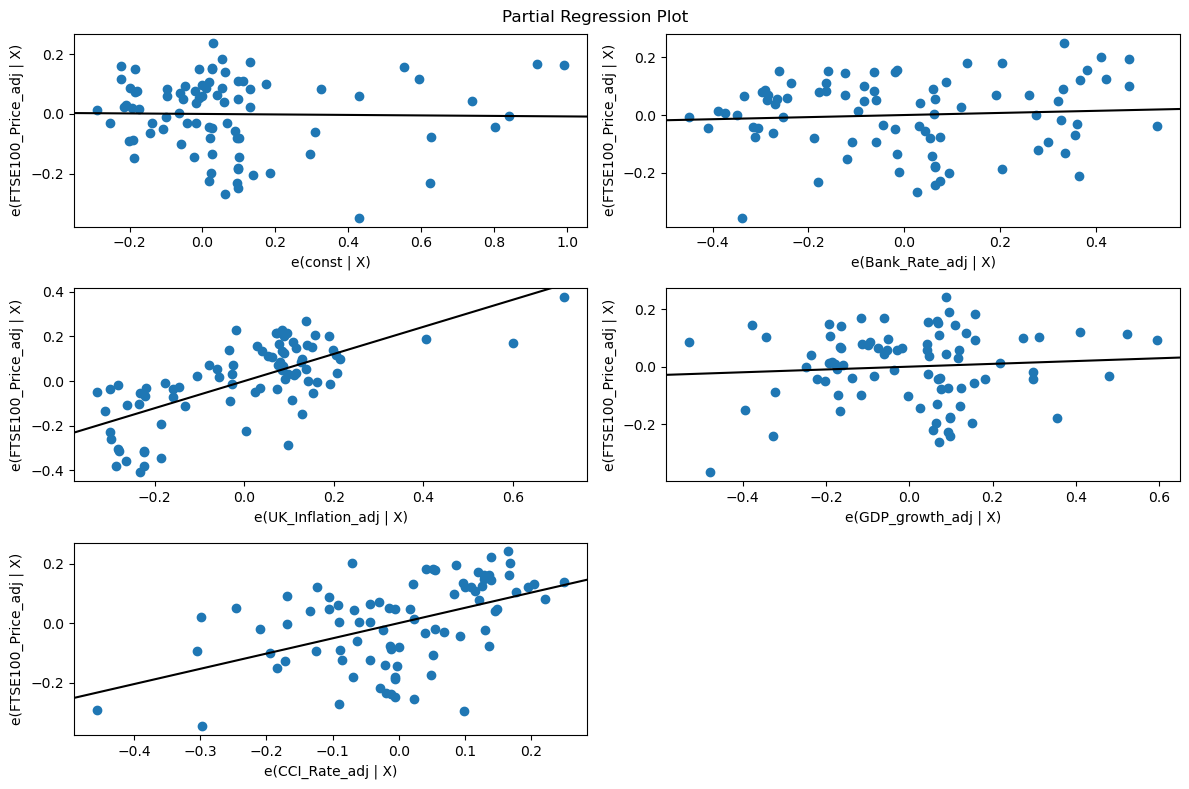

In [22]:
X = df[['Bank_Rate_adj', 'UK_Inflation_adj', 'GDP_growth_adj', 'CCI_Rate_adj']]
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = df['FTSE100_Price_adj']

X.dropna(inplace=True)
y = y.loc[X.index]

model = sm.OLS(y, X).fit()
print(model.summary())

# Plot partial regression plots
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)

# fig.savefig('./fig/graph_' + x + '.png')

with open('./Results/regression_summary_' + 'BoE Rate, UK_Inflation, GDP growth, CCI Rate' + '.txt', 'w') as file:
    file.write(model.summary().as_text())

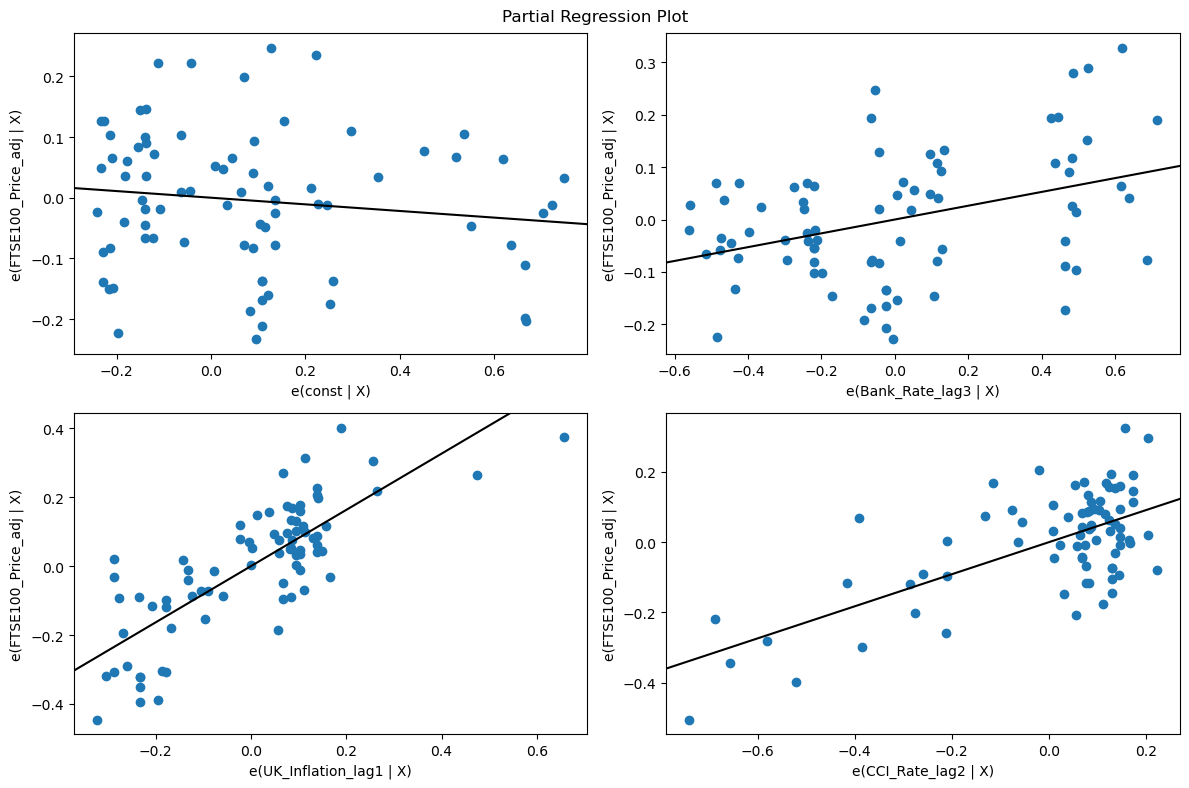

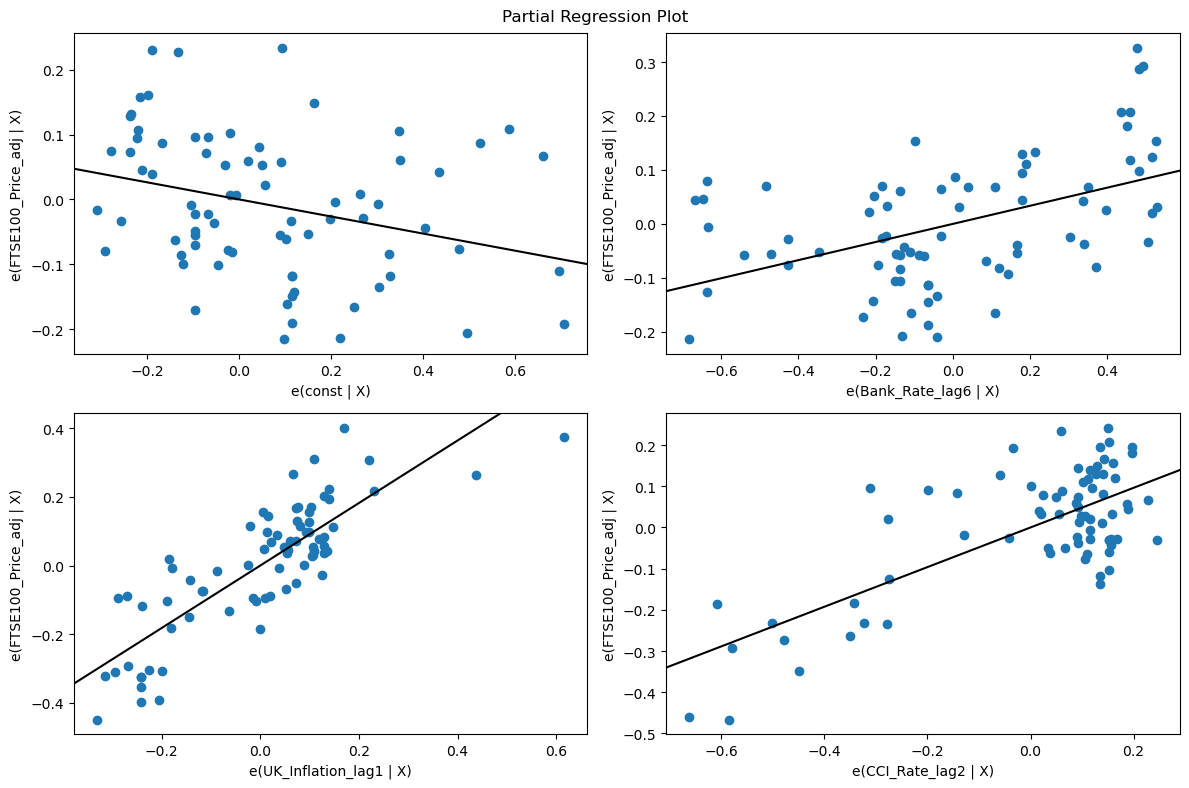

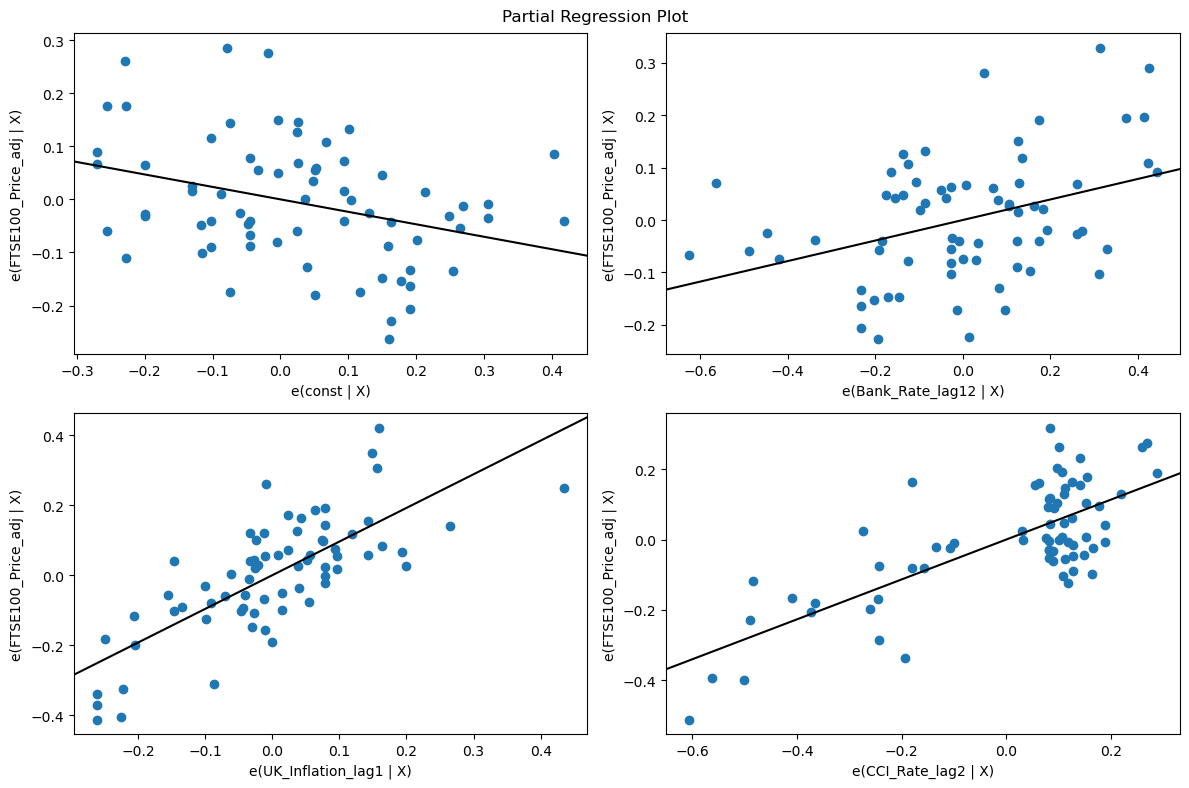

In [23]:
for x in ['Bank_Rate_lag3', 'Bank_Rate_lag6', 'Bank_Rate_lag12']:
    X = df[[x, 'UK_Inflation_lag1', 'CCI_Rate_lag2']]
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    y = df['FTSE100_Price_adj']
    
    X.dropna(inplace=True)
    y = y.loc[X.index]
    
    model = sm.OLS(y, X).fit()
    
    # Plot partial regression plots
    fig = plt.figure(figsize=(12, 8))
    fig = sm.graphics.plot_partregress_grid(model, fig=fig)
    
    
    fig.savefig('./fig/lags/UK/graph_' + x + '.png')
    
    with open('./Results/lags/UK/regression_summary_' + x + '.txt', 'w') as file:
        file.write(model.summary().as_text())